In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [9]:
# Get table info using inspector
inspector = inspect(engine)
mcolumns = inspector.get_columns('Measurement')
scolumns = inspector.get_columns('Station')

# Display column names & data types for each table
print('Measurement:')
for c in mcolumns:
    print(c['name'], c['type'])
print('-'*12)
print('Station:')
for c in scolumns:
    print(c['name'], c['type'])

Measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
Station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print(most_recent)

2017-08-23


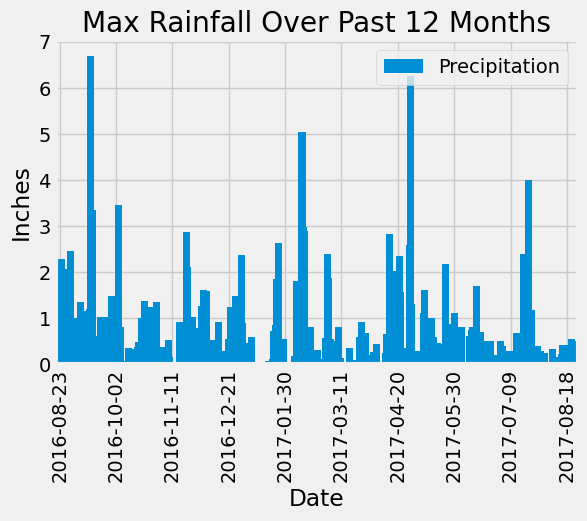

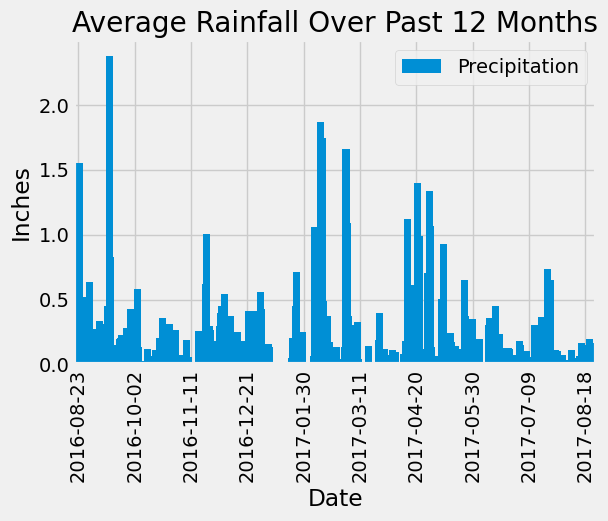

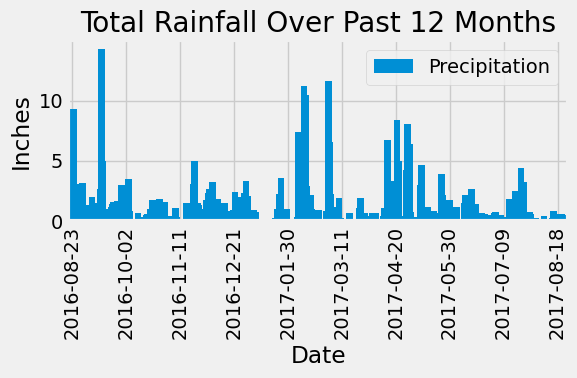

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last = dt.datetime.strptime(most_recent, "%Y-%m-%d").date()
twelve_mo = last - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= twelve_mo)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns=['Date', 'Precipitation'])
prcp = df.set_index('Date')
gbo = prcp.groupby('Date')

# Group results by date & get various summary stats to graph
max = gbo.max()
ave = gbo.mean()
tot = gbo.sum()

# Create function to sort each dataframe and graph the results
def plot(df:pd.DataFrame, title:str)->None:

    # Sort the dataframe by date
    sortd = df.sort_index()

    # Use Pandas Plotting with Matplotlib to plot the data
    ax = sortd.plot(kind='bar', figsize=(6, 4), width=5)
    ax.set_xticks(ax.get_xticks()[::40])
    plt.ylabel('Inches')
    plt.title(title)

# Call the plot function for each statistic and display the resulting graphs
plot(max, 'Max Rainfall Over Past 12 Months')
plot(ave, 'Average Rainfall Over Past 12 Months')
plot(tot, 'Total Rainfall Over Past 12 Months')
plt.tight_layout()
plt.show()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp.agg({"Precipitation":['count', 'sum', 'mean', 'median', 'max', 'min', 'var', 'std']})


,Precipitation
count,2021.000000
sum,358.280000
mean,0.177279
median,0.020000
max,6.700000
min,0.000000
var,0.212696
std,0.461190


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
numstations = session.query(Measurement).group_by(Measurement.station).count()
print(f"The total number of stations in the dataset is {numstations}")


The total number of stations in the dataset is 9


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
active_stations = session.query(func.count(Measurement.station).label('count'), Measurement.station, Station.name)\
.filter(Station.station == Measurement.station)\
.group_by(Measurement.station)\
.order_by(desc('count'))

# List the stations and the counts in descending order.
for station in active_stations:
    print(station.count, station.station, station.name)


2772 USC00519281 WAIHEE 837.5, HI US
2724 USC00519397 WAIKIKI 717.2, HI US
2709 USC00513117 KANEOHE 838.1, HI US
2669 USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US
2612 USC00516128 MANOA LYON ARBO 785.2, HI US
2202 USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US
1979 USC00511918 HONOLULU OBSERVATORY 702.2, HI US
1372 USC00517948 PEARL CITY, HI US
511 USC00518838 UPPER WAHIAWA 874.3, HI US


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Get the most active station from the previous query
most_active = active_stations.first()

# Design queries to gather the lowest, highest, and average temperatures from that station
lowest, = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active.station).one()
highest, = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active.station).one()
average_temp, = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active.station).one()

# Print the results of those queries
print(f"The highest temperature from the most active station was {highest} degrees Fahrenheit")
print(f"The lowest temperature from the most active station was {lowest} degrees Fahrenheit")
print(f"The average temperature from the most active station was {round(average_temp, 1)} degrees Fahrenheit")


The highest temperature from the most active station was 85.0 degrees Fahrenheit
The lowest temperature from the most active station was 54.0 degrees Fahrenheit
The average temperature from the most active station was 71.7 degrees Fahrenheit


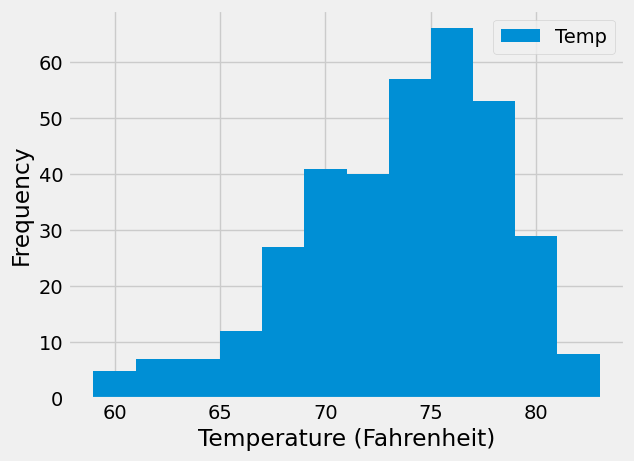

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
tempobvs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active.station).filter(Measurement.date >= twelve_mo)

# Create a dataframe to hold this query data for graphing
df2 = pd.DataFrame(tempobvs, columns=['Date', 'Temp'])

# Set index to the 'Date' column & sort by date
tobs = df2.set_index('Date').sort_index()

# Plot the results as a histogram
tobs.plot(kind='hist', bins=12)
plt.xlabel('Temperature (Fahrenheit)')
plt.show()

# Close session

In [17]:
# Close Session
session.close()